In [1]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints, MultivariateNormal
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.util import get_rng_state

In [17]:
p = 0.6
n_sample = 1000
mask = dist.Bernoulli(probs=p).sample((n_sample,))
loc1, loc2 = -4.0, 3.0
scale = 0.5
data = dist.MaskedMixture(mask.bool(),
                         dist.Normal(loc1, scale),
                         dist.Normal(loc2, scale)).sample()

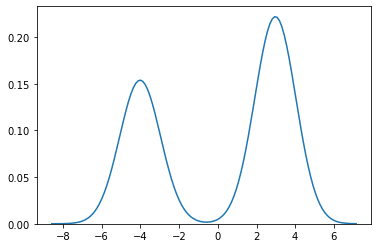

In [18]:
sns.kdeplot(data.numpy())

In [84]:
def model(data):
    weights = pyro.param('weights', torch.tensor(0.5))
    locs = pyro.param('locs', torch.randn(2,))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Bernoulli(weights)).long()
        pyro.sample('obs', dist.Normal(locs[assignment], 1.0))

T = 0.1
def guide(data):
    with pyro.plate('data', len(data)):
        alpha = pyro.param('alpha', torch.ones(len(data)) * 0.5, constraints.unit_interval)
        pyro.sample('assignment', dist.RelaxedBernoulliStraightThrough(torch.tensor(T), probs=alpha))
        
def train(data, svi, num_iterations):
    losses = []
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)
    return losses

In [85]:
def initialize(seed, data, model, guide, optim):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    svi = SVI(model, guide, optim, Trace_ELBO(num_particles=50))
    return svi.loss(model, guide, data)

In [86]:
loss, seed = min(
    [(initialize(seed, data, model, guide, optim),seed) for seed in range(100)]
)
print(loss, seed)

8301.221176757812 1


In [75]:
n_iter = 100
pyro.clear_param_store()
pyro.set_rng_seed(seed)
optim = Adam({'lr': 0.2, 'betas': [0.9, 0.99]})
svi = SVI(model, guide, optim, loss=Trace_ELBO(num_particles=50))
losses = train(data, svi, n_iter)

In [76]:
losses

[8301.221166992187,
 8491.056929931643,
 8420.514141845702,
 8438.507695312497,
 8509.756331787108,
 8490.523221435546,
 8495.229700927735,
 8408.520804443358,
 8407.630356445312,
 8434.38468017578,
 8429.483593749997,
 8408.400427246095,
 8394.73835205078,
 8397.981290283205,
 8460.669860839844,
 8432.17291015625,
 8470.386202392578,
 8446.488541259765,
 8422.003920898438,
 8425.477233886717,
 8457.58980957031,
 8418.154117431643,
 8423.279194335937,
 8430.300615234375,
 8436.026270751954,
 8411.145355224608,
 8389.055625,
 8392.21465942383,
 8437.152952880859,
 8447.271264648442,
 8399.399343261719,
 8365.215833740232,
 8442.823289794922,
 8419.937193603515,
 8415.03077392578,
 8421.444844970707,
 8402.832186279298,
 8411.77419189453,
 8453.358541259764,
 8411.562967529298,
 8410.67894165039,
 8454.214891357422,
 8413.57502319336,
 8399.379141845702,
 8414.079338378908,
 8449.900728759765,
 8458.123488769528,
 8398.844268798828,
 8407.933559570314,
 8491.42045288086,
 8421.8499328613